In [1]:
import os
import pickle
import glob
import json

import numpy as np
import pandas as pd
from itertools import combinations
from scipy.optimize import curve_fit

from itertools import combinations
from scipy.optimize import curve_fit

import ipywidgets as widgets

%matplotlib inline

# Превращаем данные в .json в DataFrame

In [2]:
%%time

isotherms_data_folder = r'downloaded'
total = []

for json_file in glob.glob(isotherms_data_folder + r'\*.json'):
#     print(json_file)

    #read
    with open(json_file, 'r') as json_inp:
        json_data = json.load(json_inp)

    # check if only single substance was adsorbed
    if json_data['isotherm_data'][0]['species_data'][0]['composition'] != 1:
        continue
    
    category = json_data['category']
    adsorbent = json_data['adsorbent']['name']
    adsorbate = json_data['adsorbates'][0]['name']
    temperature = json_data['temperature']
    doi = json_data['DOI']
    p_units = json_data['pressureUnits']
    ads_units = json_data['adsorptionUnits']
    pressure = [d['pressure'] for d in json_data['isotherm_data']]
    adsorption = [d['total_adsorption'] for d in json_data['isotherm_data']]

    total.append([doi, category,
                  adsorbent, adsorbate, temperature,
                  p_units, ads_units, pressure, adsorption])

Wall time: 1.75 s


In [3]:
df_sum = pd.DataFrame(total, columns=['doi', 'category',
                                      'adsorbent', 'adsorbate', 'temperature',
                                      'p_units', 'ads_units', 'pressure', 'adsorption'])

# Все возможные величины адсорбции в данном датасете

Из всех видов были выбраны `mmol/g`, `cm3(STP)/g`, `mg/g`, `ml/g`, `mol/g`, `mmol/kg`. В следующем блоке показано количество разных величин.

In [4]:
df_sum['ads_units'].value_counts()

mmol/g                        1558
cm3(STP)/g                     790
wt%                            143
molecules/unitcell             110
mg/g                            98
ml/g                            44
cm3(STP)/cm3                    38
mmol/cm3                        38
mol/mol                         18
mol/m3                          16
mol/l                           10
mg/m2                            8
kmol/m3                          7
molecules/cage                   6
                                 6
cm3/m2                           5
molecules/Cu2 unit               3
molecules/Rh2 unit               3
molecules/8 unit cells           3
Guest molecules per Cu ion       2
g/l                              2
mmol/m2                          2
molecules/nm2                    2
mol/g                            2
mmol/kg                          1
molecules/formula unit           1
mol/m2                           1
molecules/pore                   1
Name: ads_units, dty

# Блок перевода величин

Из всего перечня величин было решено оставить самую распространенную как основную, и по возможности перевести остальные.

In [5]:
df_ads = df_sum.copy()
chosen_ads_units = list(df_ads[df_ads['ads_units'] == 'mmol/g'].index) \
                 + list(df_ads[df_ads['ads_units'] == 'cm3(STP)/g'].index) \
                 + list(df_ads[df_ads['ads_units'] == 'mg/g'].index) \
                 + list(df_ads[df_ads['ads_units'] == 'ml/g'].index) \
                 + list(df_ads[df_ads['ads_units'] == 'mol/g'].index) \
                 + list(df_ads[df_ads['ads_units'] == 'mmol/kg'].index) 
df_ads = df_ads[df_ads.index.isin(chosen_ads_units)]
df_ads['ads_units'].value_counts()

mmol/g        1558
cm3(STP)/g     790
mg/g            98
ml/g            44
mol/g            2
mmol/kg          1
Name: ads_units, dtype: int64

Из всего перечня величин можно перевести 5 в `mmol/g`. В следующем блоке - код перевода величин. Для перевода из:

- `cm3(STP)/g` или `ml/g` в `mmol/g` нужно поделить на 22,4
- `mg/g` в `mmol/g` нужно поделить на 44,0
- `mol/g` в `mmol/g` нужно умножить на 1000
- `mmol/kg` в `mmol/g` нужно поделить на 1000


In [6]:
df_prep = df_ads.dropna()
for i, row in df_prep.iterrows():
    if row['ads_units'] == 'cm3(STP)/g' or row['ads_units'] == 'ml/g':
        try:
            new_value = np.true_divide(row['adsorption'], 22.4)
        except:
            new_value = np.nan
        df_prep.at[i,'ads_units'] = 'mmol/g'
        df_prep.at[i,'adsorption'] = new_value
    elif row['ads_units'] == 'mg/g':
        try:
            new_value = np.true_divide(row['adsorption'], 44.0)
        except:
            new_value = np.nan
        df_prep.at[i,'ads_units'] = 'mmol/g'
        df_prep.at[i,'adsorption'] = new_value
    elif row['ads_units'] == 'mol/g':
        try:
            new_value = np.multiply(row['adsorption'], 1000.0)
        except:
            new_value = np.nan
        df_prep.at[i,'ads_units'] = 'mmol/g'
        df_prep.at[i,'adsorption'] = new_value
    elif row['ads_units'] == 'mmol/kg':
        try:
            new_value = np.true_divide(row['adsorption'], 1000.0)
        except:
            new_value = np.nan
        df_prep.at[i,'ads_units'] = 'mmol/g'
        df_prep.at[i,'adsorption'] = new_value    
    elif row['ads_units'] == 'mmol/g':
        if None in row['adsorption']:
            df_prep.at[i,'adsorption'] = np.nan
df_prep = df_prep.dropna()
df_prep['ads_units'].value_counts()

mmol/g    2160
Name: ads_units, dtype: int64

# DataFrame после перевода величин (первые 50 записей)

In [7]:
df_prep.reset_index(inplace=True, drop=True)
df_prep.head(50)

,doi,category,adsorbent,adsorbate,temperature,p_units,ads_units,pressure,adsorption
0,10.1002/adfm.201200084,,NH2-MIL-53(Al),Carbon Dioxide,273,bar,mmol/g,"[0.42318, 0.676969, 1.01993, 1.36288, 1.70644,...","[0.3864669642857143, 0.6226428571428572, 0.772..."
1,10.1002/adfm.201200084,,NH2-MIL-53(Al),Carbon Dioxide,298,bar,mmol/g,"[0.678881, 1.35654, 1.86693, 2.54398, 3.22102,...","[0.09775803571428571, 0.17922321428571428, 0.2..."
2,10.1002/adfm.201300071,,CCT1,Carbon Dioxide,273,bar,mmol/g,"[0.0126608, 0.0422383, 0.0746326, 0.112661, 0....","[0.098115625, 0.2917776785714286, 0.4275924107..."
3,10.1002/adfm.201300071,,CCT1,Carbon Dioxide,273,bar,mmol/g,"[0.0182946, 0.0408298, 0.0816749, 0.129562, 0....","[0.09057053571428571, 0.2188401785714286, 0.33..."
4,10.1002/adfm.201300071,,CT,Carbon Dioxide,273,bar,mmol/g,"[0.0408298, 0.0999848, 0.161957, 0.218295, 0.2...","[0.18865892857142857, 0.34710982142857144, 0.4..."
5,10.1002/adfm.201300071,,CCT1,Carbon Dioxide,273,bar,mmol/g,"[0.0112524, 0.0816749, 0.161957, 0.221112, 0.2...","[0.098115625, 0.31944375, 0.45777232142857144,..."
6,10.1002/adfm.201300071,,CCT1,Carbon Dioxide,273,bar,mmol/g,"[0.0112524, 0.078858, 0.130971, 0.192943, 0.28...","[0.098115625, 0.26159642857142856, 0.349625, 0..."
7,10.1002/adfm.201300071,,CCT1,Carbon Dioxide,273,bar,mmol/g,"[0.0689988, 0.15914, 0.221112, 0.280266, 0.339...","[0.08554017857142858, 0.17859866071428573, 0.2..."
8,10.1002/adfm.201300071,,CCT1,Carbon Dioxide,273,bar,mmol/g,"[0.0422383, 0.0999848, 0.161957, 0.250689, 0.3...","[0.030208303571428573, 0.07547991071428571, 0...."
9,10.1002/adfm.201300071,,CT,Carbon Dioxide,273,bar,mmol/g,"[0.02252, 0.0661819, 0.160548, 0.253506, 0.345...","[0.04278375, 0.098115625, 0.16853839285714287,..."


# Построение изотерм адсорбции с помощью выбранного уравнения

Для построения изотерм выбрали 3 уравнения:

- `freundlich_langmuir_model` (`FL`) - уравнение Фрейндлиха-Лангмюира.
- `langmuir_model` (`L`) - уравнение Лангмюира.
- `freundlich_model` (`F`) - уравнение Фрейндлиха.

Также расчет R^2

In [8]:
def freundlich_langmuir_model(p, g_inf, K, n):
      return (g_inf * (K*p)**(1/n)/(1 + (K*p)**(1/n)))

In [9]:
def langmuir_model(p, g_inf, K):
    return (g_inf * (K*p))/(1 + (K*p))

In [10]:
def freundlich_model(p, K, n):
    return (K*(p**(1/n)))

In [11]:
eq_drpdown = widgets.Dropdown(
    options=['FL', 'L', 'F'],
    value='FL',
    description='Equation:',
    disabled=False,
)
eq_drpdown

Dropdown(description='Equation:', options=('FL', 'L', 'F'), value='FL')

Рассчитываются коэффициенты по уравнению адсорбции Ленгмюра-Фрейндлиха. 
В нем константы `K` и `n` находятся графическим способом, следовательно, для определения допустимых значений были выделены следующие критерии: 
- Для константы `n` (тангенс угла наклона прямой по зависимости lgA от lgP) 1 < `n` < 10 (по найденным критериям для `n`). 
- Константа `K` так же находится графически, как точка пересечения прямой по зависимости lgA от lgP с осью y (при P=1) для этого на диапазон значения влияют исходные данные в которых выбирается координаты точки при которых lgP=0, либо ближайшее к нему значение. 
- Минимальное значение `g_inf` (предельная адсорбция) принимает значение максимальной адсорбции по каждому конкретному случаю, максимальное значение не ограничено.

In [12]:
df_iso = df_prep.copy()

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def fit_isotherm(pressure, adsorption, model, model_parameters_bounds=([0.0, 2.0, 1.11], [np.inf, 2.50, 10.0])):
    """
    curve_fit function from SciPy
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html
    """
    B = adsorption[find_nearest(pressure, 1.0)]
    if eq_drpdown.value == 'FL':
        curve = [np.nan, np.nan, np.nan]
        model_parameters_bounds=([np.max(adsorption), B - (B/3), 1.11], 
                                 [np.inf, B + (B/3), 10.0])
    elif eq_drpdown.value == 'L':
        curve = [np.nan, np.nan]
        # 1-ый вариант
#         model_parameters_bounds=([np.max(adsorption), B - (B/3)],
#                                  [np.inf, B + (B/3)])
        # нужный вариант
        model_parameters_bounds=([0.0, 0.0],
                                 [np.inf, np.inf])
    elif eq_drpdown.value == 'F':
        curve = [np.nan, np.nan]
        model_parameters_bounds=([B - (B/3), 1.11],
                                 [B + (B/3), 10.0])
    try:
        curve, _ = curve_fit(f=model, xdata=pressure, ydata=adsorption,
                             bounds=model_parameters_bounds)
    except RuntimeError:
        pass
    except ValueError:
        pass
    finally:
        try:
            res = adsorption - model(np.array(pressure), *curve)
        except TypeError:
            curve = np.append(curve, np.nan)
        else:
            ss_res = np.sum(pow(res, 2))
            ss_tot = np.sum((adsorption-np.mean(adsorption))**2)
            r_squared = 1 - (ss_res / ss_tot)
            if r_squared <= 0:
                r_squared = 0
            curve = np.append(curve, r_squared)
        return curve

In [13]:
%%time
if eq_drpdown.value == 'FL':
    df_iso['g_inf'], df_iso['K'], df_iso['n'], df_iso['R^2'] = \
    zip(*df_iso[['pressure', 'adsorption']].apply(lambda data: fit_isotherm(data[0], data[1], freundlich_langmuir_model), axis=1))
elif eq_drpdown.value == 'L':
    df_iso['g_inf'], df_iso['K'], df_iso['R^2'] = \
    zip(*df_iso[['pressure', 'adsorption']].apply(lambda data: fit_isotherm(data[0], data[1], langmuir_model), axis=1))
elif eq_drpdown.value == 'F':
    df_iso['K'], df_iso['n'], df_iso['R^2'] = \
    zip(*df_iso[['pressure', 'adsorption']].apply(lambda data: fit_isotherm(data[0], data[1], freundlich_model), axis=1))

D:\Anaconda\lib\site-packages\scipy\optimize\minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars


Wall time: 22.2 s


In [15]:
df_iso = df_iso.dropna()
df_iso.reset_index(inplace=True, drop=True)
df_iso['doi'] = "http://dx.doi.org/"+ df_iso['doi']
# Saving to excel
if eq_drpdown.value == 'FL':
    df_iso.to_excel("CO2_mmol_g_FL.xlsx")
elif eq_drpdown.value == 'L':
    df_iso.to_excel("CO2_mmol_g_L.xlsx")
elif eq_drpdown.value == 'F':
    df_iso.to_excel("CO2_mmol_g_F.xlsx")
df_iso['ads_units'].value_counts()

mmol/g    1954
Name: ads_units, dtype: int64

In [16]:
df_iso.head(50)

,doi,category,adsorbent,adsorbate,temperature,p_units,ads_units,pressure,adsorption,g_inf,K,R^2
0,http://dx.doi.org/10.1002/adfm.201200084,,NH2-MIL-53(Al),Carbon Dioxide,273,bar,mmol/g,"[0.42318, 0.676969, 1.01993, 1.36288, 1.70644,...","[0.3864669642857143, 0.6226428571428572, 0.772...",3.235962,0.206426,0.973719
1,http://dx.doi.org/10.1002/adfm.201200084,,NH2-MIL-53(Al),Carbon Dioxide,298,bar,mmol/g,"[0.678881, 1.35654, 1.86693, 2.54398, 3.22102,...","[0.09775803571428571, 0.17922321428571428, 0.2...",2.743010,0.048580,0.995877
2,http://dx.doi.org/10.1002/adfm.201300071,,CCT1,Carbon Dioxide,273,bar,mmol/g,"[0.0126608, 0.0422383, 0.0746326, 0.112661, 0....","[0.098115625, 0.2917776785714286, 0.4275924107...",1.801740,3.012629,0.984611
3,http://dx.doi.org/10.1002/adfm.201300071,,CCT1,Carbon Dioxide,273,bar,mmol/g,"[0.0182946, 0.0408298, 0.0816749, 0.129562, 0....","[0.09057053571428571, 0.2188401785714286, 0.33...",1.954641,2.058002,0.991906
4,http://dx.doi.org/10.1002/adfm.201300071,,CT,Carbon Dioxide,273,bar,mmol/g,"[0.0408298, 0.0999848, 0.161957, 0.218295, 0.2...","[0.18865892857142857, 0.34710982142857144, 0.4...",1.767504,2.060469,0.992460
5,http://dx.doi.org/10.1002/adfm.201300071,,CCT1,Carbon Dioxide,273,bar,mmol/g,"[0.0112524, 0.0816749, 0.161957, 0.221112, 0.2...","[0.098115625, 0.31944375, 0.45777232142857144,...",1.592324,2.275958,0.988556
6,http://dx.doi.org/10.1002/adfm.201300071,,CCT1,Carbon Dioxide,273,bar,mmol/g,"[0.0112524, 0.078858, 0.130971, 0.192943, 0.28...","[0.098115625, 0.26159642857142856, 0.349625, 0...",1.224797,2.685078,0.986386
7,http://dx.doi.org/10.1002/adfm.201300071,,CCT1,Carbon Dioxide,273,bar,mmol/g,"[0.0689988, 0.15914, 0.221112, 0.280266, 0.339...","[0.08554017857142858, 0.17859866071428573, 0.2...",3.171433,0.340284,0.998344
8,http://dx.doi.org/10.1002/adfm.201300071,,CCT1,Carbon Dioxide,273,bar,mmol/g,"[0.0422383, 0.0999848, 0.161957, 0.250689, 0.3...","[0.030208303571428573, 0.07547991071428571, 0....",8.110181,0.089948,0.999719
9,http://dx.doi.org/10.1002/adfm.201300071,,CT,Carbon Dioxide,273,bar,mmol/g,"[0.02252, 0.0661819, 0.160548, 0.253506, 0.345...","[0.04278375, 0.098115625, 0.16853839285714287,...",1.022613,1.104474,0.994081


# Поиск ref кода

In [19]:
conq = pd.read_excel("conquest.xlsx")

In [20]:
df_fin = pd.merge(df_iso,conq,on='doi', how='left')
df_fin.to_excel("CO2_mmol_g_Langmuer_ref.xlsx")

# Распределение R^2

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000017D283CB288>]],
      dtype=object)

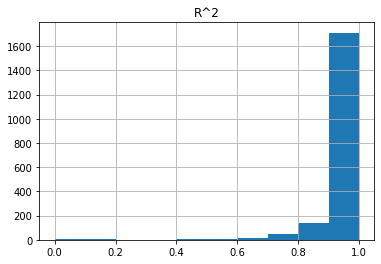

In [16]:
df_iso.hist(column='R^2')

Математическое ожидание по выборке(общее для сравниваемых распределений) -0.783
СКО по выборке(общее для сравниваемых распределений) -0.246
Энтропийное значение погрешности-0.508


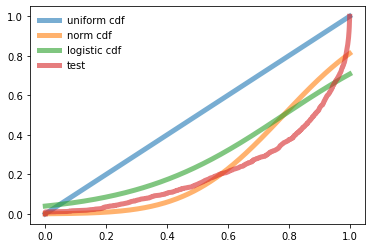

Корреляция между нормальным  распределением и тестовым - 0.943
Корреляция между логистическим  распределением и тестовым - 0.932
Корреляция между равномерным  распределением и тестовым - 0.901
Взвешенная сумма  квадратов отклонения нормального распределения от теста -5678013
Взвешенная сумма квадратов отклонения логистического распределения от теста -417500


D:\Anaconda\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in true_divide
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide


ValueError: cannot convert float NaN to integer

In [17]:
from scipy.stats import logistic,uniform,norm,pearsonr
from numpy import sqrt,pi,e
import numpy as np
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)
n=df_iso['R^2'].size# объём выборки
x=np.array(df_iso['R^2'])
x.sort()#сортировка 
print("Математическое ожидание по выборке(общее для сравниваемых распределений) -%s"%str(round(np.mean(x),3)))
print("СКО по выборке(общее для сравниваемых распределений) -%s"%str(round(np.std(x),3)))
print("Энтропийное значение погрешности-%s"%str(round(np.std(x)*sqrt(np.pi*np.e*0.5),3)))      
pu=uniform.cdf(x/(np.max(x)))#равномерное интегральное  распределение 
ax.plot(x,pu, lw=5, alpha=0.6, label='uniform cdf')
pn=norm.cdf(x, np.mean(x), np.std(x))#нормальное интегральное  распределение 
ax.plot(x,pn, lw=5, alpha=0.6, label='norm cdf')
pl=logistic.cdf(x, np.mean(x), np.std(x))# логистическое  интегральное  распределение 
ax.plot(x,pl, lw=5, alpha=0.6, label='logistic cdf')
p=np.arange(0,n,1)/n
ax.plot(x,p, lw=5, alpha=0.6, label='test')
ax.legend(loc='best', frameon=False)
plt.show()
print("Корреляция между нормальным  распределением и тестовым - %s"%str(round(pearsonr(pn,p)[0],3)))
print("Корреляция между логистическим  распределением и тестовым - %s"%str(round(pearsonr(pl,p)[0],3)))
print("Корреляция между равномерным  распределением и тестовым - %s"%str(round(pearsonr(pu,p)[0],3)))
print('Взвешенная сумма  квадратов отклонения нормального распределения от теста -%i'%round(n*sum(((pn-p)/pn)**2)))
print('Взвешенная сумма квадратов отклонения логистического распределения от теста -%i'%round(n*sum(((pl-p)/pl)**2)))
print('Взвешенная сумма квадратов отклонения равномерного распределения от теста -%i'%round(n*sum(((pu-p)/pu)**2)))

# Удаляем дубликаты из датасета

In [17]:
df_set = df_iso.copy()
if eq_drpdown.value == 'FL':
    df_set = df_set.drop_duplicates(subset=['g_inf', 'K', 'n', 'adsorbent'])
elif eq_drpdown.value == 'L':
    df_set = df_set.drop_duplicates(subset=['g_inf', 'K', 'adsorbent'])
elif eq_drpdown.value == 'F':
    df_set = df_set.drop_duplicates(subset=['K', 'n', 'adsorbent'])
df_set['ads_units'].value_counts()

mmol/g    1928
Name: ads_units, dtype: int64

# Построение графиков изотерм выбранного MOF из датасета

In [18]:
df_set_drpdwn = widgets.Dropdown(
    options=list(df_set.drop_duplicates(subset=['adsorbent'])['adsorbent']),
    description='MOF:',
    disabled=False,
)
df_set_drpdwn

Dropdown(description='MOF:', options=('NH2-MIL-53(Al)', 'CCT1', 'CT', 'Zn(OPE) 2H2O', 'CUK-1', 'CMS-T3A', 'MIL…

In [19]:
subset = df_set[df_set['adsorbent']== df_set_drpdwn.value]
subset

,doi,category,adsorbent,adsorbate,temperature,p_units,ads_units,pressure,adsorption,g_inf,K,R^2
0,https://doi.org/10.1002/adfm.201200084,,NH2-MIL-53(Al),Carbon Dioxide,273,bar,mmol/g,"[0.42318, 0.676969, 1.01993, 1.36288, 1.70644,...","[0.3864669642857143, 0.6226428571428572, 0.772...",3.235962,0.206426,0.973719
1,https://doi.org/10.1002/adfm.201200084,,NH2-MIL-53(Al),Carbon Dioxide,298,bar,mmol/g,"[0.678881, 1.35654, 1.86693, 2.54398, 3.22102,...","[0.09775803571428571, 0.17922321428571428, 0.2...",2.743010,0.048580,0.995877
147,https://doi.org/10.1002/ceat.201400741,exp,NH2-MIL-53(Al),Carbon Dioxide,298,bar,mmol/g,"[0.22898, 0.231476, 0.233616, 0.24503, 0.36629...","[2.34701, 2.13272, 1.94905, 0.969459, 2.56133,...",10.808187,0.170756,0.644325
277,https://doi.org/10.1002/cssc.201100378,,NH2-MIL-53(Al),Carbon Dioxide,283,bar,mmol/g,"[0.076979, 0.331972, 0.844845, 1.78752, 2.2163...","[0.835821, 1.10448, 1.37313, 1.64179, 1.73134,...",14.263024,0.044365,0.936987
545,https://doi.org/10.1016/j.ces.2014.10.028,exp,NH2-MIL-53(Al),Carbon Dioxide,257,bar,mmol/g,"[1.01761, 1.64384, 2.19178, 2.818, 3.60078, 4....","[2.35294, 2.41486, 2.47678, 2.50774, 2.60062, ...",31.036412,0.023320,0.931386
546,https://doi.org/10.1016/j.ces.2014.10.028,exp,NH2-MIL-53(Al),Carbon Dioxide,263,bar,mmol/g,"[0.156556, 0.234834, 0.391389, 0.626223, 1.565...","[2.01238, 1.9195, 2.2291, 2.29102, 2.3839, 2.4...",23.785644,0.029797,0.872740
547,https://doi.org/10.1016/j.ces.2014.10.028,exp,NH2-MIL-53(Al),Carbon Dioxide,273,bar,mmol/g,"[0.078278, 0.156556, 0.234834, 0.313112, 0.547...","[1.23839, 1.64087, 1.88854, 2.04334, 2.13622, ...",45.468685,0.008316,0.824477
548,https://doi.org/10.1016/j.ces.2014.10.028,exp,NH2-MIL-53(Al),Carbon Dioxide,298,bar,mmol/g,"[0, 0.156556, 0.234834, 0.313112, 0.704501, 1....","[1.30031, 1.11455, 1.60991, 1.76471, 1.95046, ...",10.659401,0.032265,0.529785
1608,https://doi.org/10.1021/Ie3004336,,NH2-MIL-53(Al),Carbon Dioxide,308,bar,mmol/g,"[0.0324133, 0.0870352, 0.135102, 0.18317, 0.23...","[0.09719017857142857, 0.21179866071428574, 0.3...",1.469748,1.767996,0.995290


In [20]:
subset_drpdwn = widgets.Dropdown(
    options=subset.index.values.tolist(),
    description='Choose',
    disabled=False,
)
subset_drpdwn

Dropdown(description='Choose', options=(0, 1, 147, 277, 545, 546, 547, 548, 1608), value=0)

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

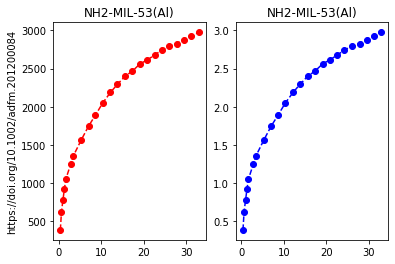

In [22]:
mof_ind = subset_drpdwn.value
plt.subplot(121)
plt.plot(df_set.loc[mof_ind, 'pressure'], 1000*np.array(df_set.loc[mof_ind, 'adsorption']), 'ro--')
plt.title(df_set.loc[mof_ind, 'adsorbent'])
plt.ylabel(df_set.loc[mof_ind, 'doi'])
plt.subplot(122)
plt.plot(df_set.loc[mof_ind, 'pressure'], df_set.loc[mof_ind, 'adsorption'], 'bo--')
plt.title(df_set.loc[mof_ind, 'adsorbent'])
plt.show()